In [1]:
# Import library 
import numpy as np

# Load data 
data_train = {'X': np.genfromtxt('Desktop/data/data_train_X.csv', delimiter=','), 
              't': np.genfromtxt('Desktop/data/data_train_y.csv', delimiter=',')}
data_test = {'X': np.genfromtxt('Desktop/data/data_test_X.csv', delimiter=','), 
             't': np.genfromtxt('Desktop/data/data_test_y.csv', delimiter=',')}

(a) Write the above 6 functions, and identify the correct order and arguments to do cross validation.

The correct order and arguments are:
1. shuffle_data(data)
2. split_data(data, num_folds, fold)
3. train_model(data, lambd)
4. predict(data, model)
5. loss(data, model)
6. cross_validation(data, num_folds, lambd_seq)

In [2]:
def shuffle_data(data):
    """
    input: 
        data: data_train
    output:
        data_shf: randomly permuted version of original data
    Description:  
        A uniformly random permutation of the training data. Note that t and phi are
        permuted the same way to keep the target-feature pairs
    """

    # create index for the training data
    index = np.arange(len(data['t']))
    
    # randomly assign target-feature pairs to different index
    index = np.random.permutation(index)
    data_shf = {'t': data['t'][index], 'X': data['X'][index, :]}

    return data_shf

In [3]:
def split_data(data, num_folds, fold):
    """
    input: 
        data: data_train
        num_folds: number of partitions chosen
        fold: the selected partition
    output:
        data_fold: the selected partition of data
        data_rest: the remaining data
    Description:
        Spilit the training data into training set and validation set 
        according to number of folds. The fold got selected contains the validation set.
        The rest is considered as training set.
    """

    # calculate how many data points are in each fold(block)
    length = len(data['t'])    
    size = int(length // num_folds)
    
    # calculate the starting and ending index for each fold(block)
    index_s = (fold - 1) * size 
    index_e = fold * size

    # Create a validation set which comes from ith fold
    data_fold = {'t': data['t'][index_s:index_e], 
               'X': data['X'][index_s:index_e, :]}
    
    # Create a training set which contains every data point except the ones in the ith fold
    data_rest = {'t': np.concatenate([data['t'][:index_s], data['t'][index_e:]], axis=0),
                 'X': np.concatenate([data['X'][:index_s], data['X'][index_e:]], axis=0)}
    
    return data_fold, data_rest

In [4]:
def train_model(data, lambd):
    """
    input: 
        data: training set
        lambd: value of lambda
    output:
        model: the coefficients of ridge regression with penalty level lambda
    Description:
        Train a ridge regression model and get the coefficients. Ignore the intercept.
    """
    
    # extract the target and feature values from the training set
    X = data['X']
    t = data['t']

    # Matrix multiplication
    XT_X = np.dot(X.T, X)
    
    # Find the coefficients of ridge regression
    model = np.dot(np.dot(np.linalg.inv(XT_X + lambd * np.identity(X.shape[1])), X.T), t)

    return model

In [5]:
def predict(data, model):
    """ 
    input: 
        data: validation set
        model: the coefficients of ridge regression based on the traning set
    output:
        predictions: target value based on model 
    Description:
        Get the predictions based on training set and model coefficients.
    """
    
    # extract features from validation set
    X = data['X']
    
    # compute the target values
    predictions = np.dot(X, model)
    
    return predictions

In [6]:
def loss(data, model):
    """
    input: 
        data: validation set
        model: the coefficients of ridge regression based on the traning set
    output:
        error: the average squared loss based on the coefficients of ridge regression
    Description:
        Calculate the mean squared error loss based on model.
    """
    
    # predicted targets
    predictions = predict(data, model)
    
    # real targets extracted from validation set
    t = data['t']
    
    # calculate the mean square error
    error = np.mean((t - predictions)**2)
    
    return error

In [7]:
def cross_validation(data, num_folds, lambd_seq): 
    '''
    input: 
        data: data_train
        num_folds: number of folds chosen
        lambda_seq: a sequence of lambda values
    output:
        cv_error: the cross validation error across all lambda values
    description:
        There is a total of 50 lambdas. For each lambda in lambd_seq, 
        split the data into <num_folds> number of folds.
        Then train the model on the training set and validate it on the validation set.
        Finally, take an average of the validation error for each specific lambda.
    '''
    
    # randomly permute data
    data = shuffle_data(data)
    
    # initialize the cross validation error
    cv_error = [0] * len(lambd_seq)
    
    # calculate the cross valudation error
    for i in range(len(lambd_seq)):
        lambd = lambd_seq[i]
        cv_loss_lmd = 0
        for fold in range(1, num_folds + 1):
            val_cv, train_cv = split_data(data, num_folds, fold)
            model = train_model(train_cv, lambd)
            cv_loss_lmd += loss(val_cv, model)
        cv_error[i] = cv_loss_lmd / num_folds
    
    return cv_error

(b) Find the training and test errors cooresponding to each lambda in lambd_seq.

In [8]:
def train_test_error(data_train, data_test, lambd_seq): 
    """
    input: 
        data_train: training data
        data_test: test data
        lambda_seq: a sequence of lambda values
    output:
        training_error: MSE using training data
        test_error: MSE using test data
    description:
        There is a total of 50 lambdas. 
        For each lambda in lambd_seq, use training data to fit a ridge regression 
        and estimate w hat. And then calculte the training error.
        Also, use the estiamted w hat and test data
        to predict the target values. And then calculate the test error.
    """
    
    # initialize the training and test error
    training_error = [0] * len(lambd_seq)
    test_error = [0] * len(lambd_seq)

    # calculate the training and test error
    for i in range(len(lambd_seq)):
        lambd = lambd_seq[i]
        model = train_model(data_train, lambd)
        training_error[i] = loss(data_train, model)
        test_error[i] = loss(data_test, model)
    
    return training_error, test_error

# take lambd_seq as evenly spaced 50 numbers over the interval [0.02, 1.5]
lambd_seq = np.arange(0.02, 1.5, (1.5-0.02) / 50)
print('lambd_seq length : {}'.format(len(lambd_seq)))

# find traning and test error
training_error, test_error = train_test_error(data_train, data_test, lambd_seq)
print('training_error length : {}'.format(len(training_error)))
print('test_error length : {}'.format(len(test_error)))


lambd_seq length : 50
training_error length : 50
test_error length : 50


In [9]:
# import library 
import pandas as pd

# Create a dataframe of training and test error for each lambda
data = {'Lambda':  lambd_seq,
        'Training Error': training_error,
        'Test Error': test_error
        }
df = pd.DataFrame(data, columns = ['Lambda', 'Training Error', 'Test Error'])
print(df)

    Lambda  Training Error  Test Error
0   0.0200        0.049736    5.106960
1   0.0496        0.104808    3.647064
2   0.0792        0.152146    3.086147
3   0.1088        0.195029    2.784853
4   0.1384        0.234971    2.599295
5   0.1680        0.272813    2.476167
6   0.1976        0.309062    2.390720
7   0.2272        0.344041    2.329798
8   0.2568        0.377969    2.285721
9   0.2864        0.410997    2.253696
10  0.3160        0.443232    2.230568
11  0.3456        0.474758    2.214174
12  0.3752        0.505635    2.202982
13  0.4048        0.535912    2.195872
14  0.4344        0.565628    2.192010
15  0.4640        0.594815    2.190762
16  0.4936        0.623500    2.191635
17  0.5232        0.651706    2.194244
18  0.5528        0.679451    2.198280
19  0.5824        0.706753    2.203498
20  0.6120        0.733627    2.209694
21  0.6416        0.760088    2.216705
22  0.6712        0.786147    2.224395
23  0.7008        0.811816    2.232649
24  0.7304        0.83710

(c) Plot training error, test error, and 5-fold and 10-fold cross validation errors on the same plot for each value in lambd_seq. What is the value of lambda proposed by cross validation procedure? Comment on the shapes of the error curves.

In [10]:
five_fold = cross_validation(data_train, 5, lambd_seq)
ten_fold = cross_validation(data_train, 10, lambd_seq)
print('five_fold length : {}'.format(len(five_fold)))
print('ten_fold length : {}'.format(len(ten_fold)))

five_fold length : 50
ten_fold length : 50


In [11]:
# Create a dataframe of 5-fold and 10-fold cross validation errors for each lambda
data1 = {'Lambda':  lambd_seq,
        'Five-Fold CV Error': five_fold,
        'Ten-Fold CV Error': ten_fold
        }
df1 = pd.DataFrame(data1, columns = ['Lambda', 'Five-Fold CV Error', 'Ten-Fold CV Error'])
print(df1)

    Lambda  Five-Fold CV Error  Ten-Fold CV Error
0   0.0200            4.105061           3.894221
1   0.0496            3.538998           3.290587
2   0.0792            3.274605           3.048222
3   0.1088            3.124482           2.917935
4   0.1384            3.031234           2.839851
5   0.1680            2.970575           2.790762
6   0.1976            2.930293           2.759491
7   0.2272            2.903532           2.739913
8   0.2568            2.886138           2.728373
9   0.2864            2.875445           2.722550
10  0.3160            2.869669           2.720897
11  0.3456            2.867569           2.722347
12  0.3752            2.868260           2.726141
13  0.4048            2.871095           2.731723
14  0.4344            2.875592           2.738682
15  0.4640            2.881386           2.746706
16  0.4936            2.888193           2.755553
17  0.5232            2.895797           2.765039
18  0.5528            2.904023           2.775015


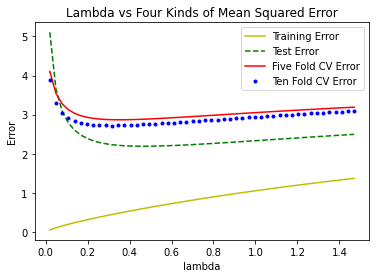

In [12]:
# Import library
import matplotlib.pyplot as plt

# plot lambda vs training/test/five-fold cv/ten-fold cv error
plt.figure()
plt.plot(lambd_seq, training_error, 'y-')
plt.plot(lambd_seq, test_error, 'g--')
plt.plot(lambd_seq, five_fold, 'r-')
plt.plot(lambd_seq, ten_fold, "b.")
plt.title("Lambda vs Four Kinds of Mean Squared Error")
plt.xlabel("lambda")
plt.ylabel("Error")
plt.legend(['Training Error', 'Test Error', 'Five Fold CV Error', 'Ten Fold CV Error'])
plt.show()


In [13]:
lambd_test = lambd_seq[test_error.index(min(test_error))]
lambd_five_fold= lambd_seq[five_fold.index(min(five_fold))]
lambd_ten_fold = lambd_seq[ten_fold.index(min(ten_fold))]
print('The value of lambda proposed by five-fold cross validation : {}'.format(round(lambd_five_fold,4)))
print('The value of lambda proposed by ten-fold cross validation : {}'.format(round(lambd_ten_fold,4)))

The value of lambda proposed by five-fold cross validation : 0.3456
The value of lambda proposed by ten-fold cross validation : 0.316


The shape of training error is like a half arch. The training error is always increasing as lambda increases.
The shapes of test error, five-fold cross validation error, and ten-fold cross validation error are like sickles. The error curves of these three types decrease at the beginning and then start to increase gradually as lambda increases.